## Jensen and Janes dataset - using PLSR to predict VPR from signaling measurements

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.io
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut





# load the colormap 
# This can be used to setup the exact color map
array_map_file = 'arraymap.mat'
array_map = scipy.io.loadmat(array_map_file)

#load the dataframe
data = pd.read_csv('Jensen_Janes_data_integral.csv', index_col=0)
vpr = pd.read_csv('Jensen_Janes_VPR.csv', index_col=0)

#take the zscore of the data and the VPR and plot these.
df_VPR_zscore = vpr.apply(stats.zscore, axis=0, nan_policy='omit')
df_data_zscore = data.apply(stats.zscore, axis=0, nan_policy='omit')


# Remove the DMSO control and perform PCA
data_sub = data.drop(index=['DMSO'])
vpr_sub = vpr.drop(index=['DMSO'])
df_data_sub_zscore = data_sub.apply(stats.zscore, axis=0, nan_policy='omit')
df_vpr_sub_zscore = vpr_sub.apply(stats.zscore, axis=0, nan_policy='omit')

# For our purposes, we'll set X and Y to the zscore, without DMSO
X = df_data_sub_zscore
Y = df_vpr_sub_zscore


# PLSR - first evaluate an all component model
This will help decide how many PCs are necessary. Let's compare/contrast fit and test for an all component and a smaller component model

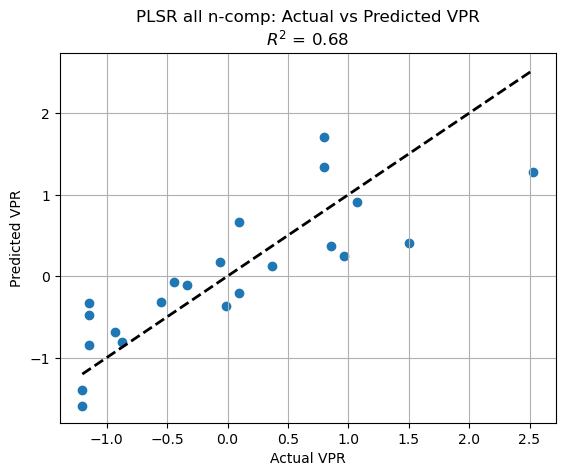

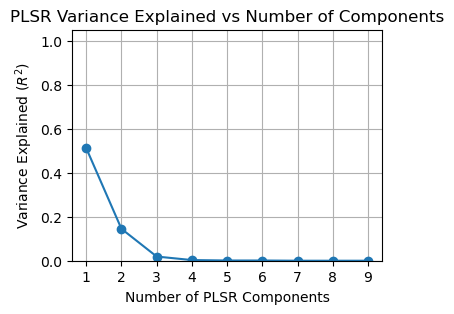

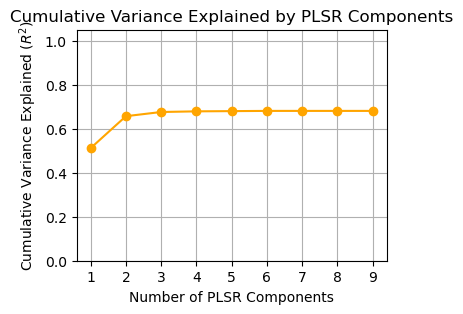

In [6]:
# run a PLSR between vpr_sub and data_sub (both zscored and without DMSO)
pls_num_components = X.shape[1]

# first run a model with all components and look at the variance explained
pls_full_model = PLSRegression(n_components=pls_num_components)
pls_full_model.fit(X, Y)

# Let's look at the predictions of the model
Y_full_pred = pls_full_model.predict(X)
ss_total_full = np.sum((Y.values - np.mean(Y.values))**2)
ss_residual_full = np.sum((Y.values - Y_full_pred)**2)
r_squared_full = 1 - (ss_residual_full / ss_total_full)
plt.scatter(Y, Y_full_pred)

# add a perfect fit line
plt.plot([Y.values.min(), Y.values.max()], [Y.values.min(), Y.values.max()], 'k--', lw=2)
plt.xlabel('Actual VPR')
plt.ylabel('Predicted VPR')
plt.title('PLSR all n-comp: Actual vs Predicted VPR\n$R^2$ = %0.2f' % r_squared_full)
plt.grid()
plt.show()

# This calls a function to calculate the percent variance explained by each component and it will
# plot the scree plots, variance explained and cumulative variance explained
perc_var_explained = plsr_variance_explained(pls_full_model, X, Y)
  



In [ ]:
def cross_validation_loo(X, Y, n_comp):
    """
    Perform Leave-One-Out Cross-Validation for PLS Regression.

    Parameters:
    X : array-like, shape (n_samples, n_features)
        The input data.
    Y : array-like, shape (n_samples, n_targets)
        The target data.
    n_comp : int
        Number of PLS components.

    Returns:
    r2_train : float
        R^2 score for the training set.
    r2_test : float
        R^2 score for the test set.
    mse_train : float
        Mean Squared Error for the training set.
    mse_test : float
        Mean Squared Error for the test set.
    """
    loo = LeaveOneOut()
    r2_train = []
    r2_test = []
    mse_train = []
    mse_test = []
    
    pls_model = PLSRegression(n_components=n_comp)
    
    y_true = []
    y_pred = []
    y_train_true = []
    y_train_pred = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        pls_model.fit(X_train, Y_train)
        
        Y_test_pred = pls_model.predict(X_test)
        Y_train_pred = pls_model.predict(X_train)
        
        y_true.append(Y_test.values[0])
        y_pred.append(Y_test_pred[0])
        
        y_train_true.extend(Y_train.values.flatten())
        y_train_pred.extend(Y_train_pred.flatten())
    
    r2_test.append(r2_score(y_true, y_pred))
    r2_train.append(r2_score(y_train_true, y_train_pred))
    
    mse_test.append(mean_squared_error(y_true, y_pred))
    mse_train.append(mean_squared_error(y_train_true, y_train_pred))
    
    return y_true, y_pred, r2_train, r2_test, mse_train, mse_test



In [ ]:
r2_train

In [ ]:
loo = LeaveOneOut()
r2_train = []
r2_test = []
mse_train = []
mse_test = []
n_comp = 9
pls_model = PLSRegression(n_components=n_comp)
y_true = []
y_pred = []
y_train_true = []
y_train_pred = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    pls_model.fit(X_train, Y_train)
    Y_test_pred = pls_model.predict(X_test)
    Y_train_pred = pls_model.predict(X_train)
    y_true.append(Y_test.values[0])
    y_pred.append(Y_test_pred[0])
    y_train_true.extend(Y_train.values.flatten())
    y_train_pred.extend(Y_train_pred.flatten())
r2_test.append(r2_score(y_true, y_pred))
r2_train.append(r2_score(y_train_true, y_train_pred))
mse_test.append(mean_squared_error(y_true, y_pred))
mse_train.append(mean_squared_error(y_train_true, y_train_pred))

# Plot the scatter plot of actual vs predicted for the test set, include the Q^2 value
plt.figure(figsize=(4, 3))
plt.scatter(y_true, y_pred, c='black', alpha=0.5)
plt.xlabel('Actual VPR')
plt.ylabel('Predicted VPR')
plt.title('PLSR LOO CV: Actual vs Predicted VPR ncomp=%d \n$Q^2$ = %0.2f' % (n_comp, r2_test[0]))
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.grid()
plt.show()

In [5]:
def plsr_variance_explained(pls_model, X, Y):
    """
    Given a fitted PLSRegression model, calculate the variance explained (R^2)
    for the response variable.
    Parameters:
    pls_model (PLSRegression): A fitted PLSRegression model.
    X (pd.DataFrame): The predictor variables used in the model.
    Y (pd.DataFrame): The response variable used in the model.
    Returns:
    perc_var_explained: list of floats, The R^2 value indicating variance explained for each component.
    """
    max_components = pls_model.n_components
    perc_var_explained = []
    for i in range(0,max_components):
        Y_pred2=np.dot(pls_model.x_scores_[:,i].reshape(-1,1),pls_model.y_loadings_[:,i].reshape(-1,1).T)+Y.mean(axis=0)[0]
        perc_var_explained.append(round(r2_score(Y,Y_pred2),3)) 

    plt.figure(figsize=(4, 3))
    plt.plot(range(1, max_components + 1), perc_var_explained, marker='o')
    plt.title('PLSR Variance Explained vs Number of Components')
    plt.xlabel('Number of PLSR Components')
    plt.ylabel('Variance Explained ($R^2$)')
    plt.xticks(range(1, max_components + 1))
    plt.ylim(0, 1.05)
    plt.grid()
    plt.show()

        # plot the cumulative variance explained
    plt.figure(figsize=(4, 3))
    cum_perc_var_explained = np.cumsum(perc_var_explained)
    plt.plot(range(1, pls_num_components + 1), cum_perc_var_explained, marker='o', color='orange')
    plt.title('Cumulative Variance Explained by PLSR Components')
    plt.xlabel('Number of PLSR Components')
    plt.ylabel('Cumulative Variance Explained ($R^2$)')
    plt.xticks(range(1, pls_num_components + 1))
    plt.ylim(0, 1.05)
    plt.grid()
    plt.show()
    return perc_var_explained

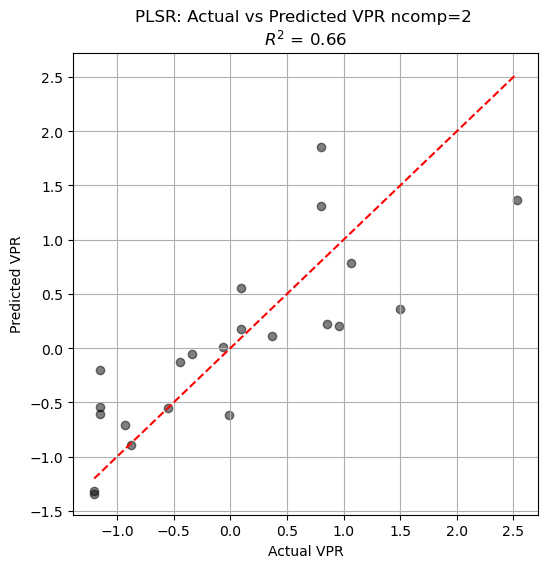

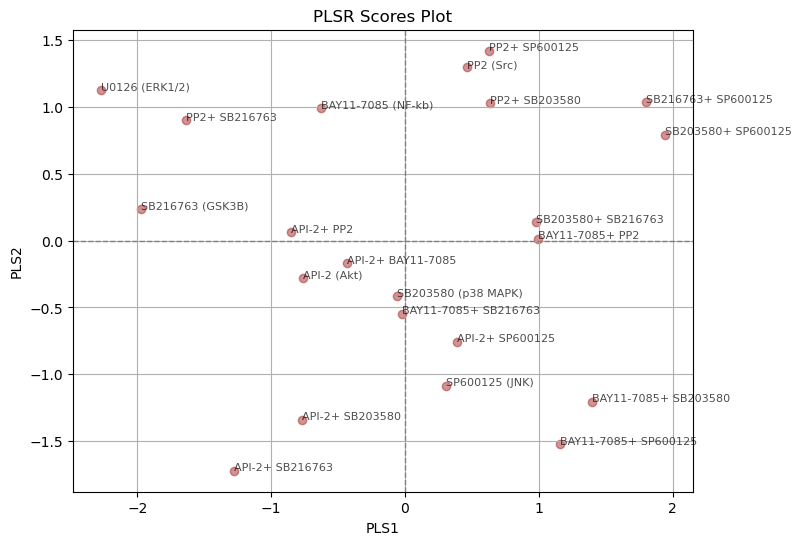

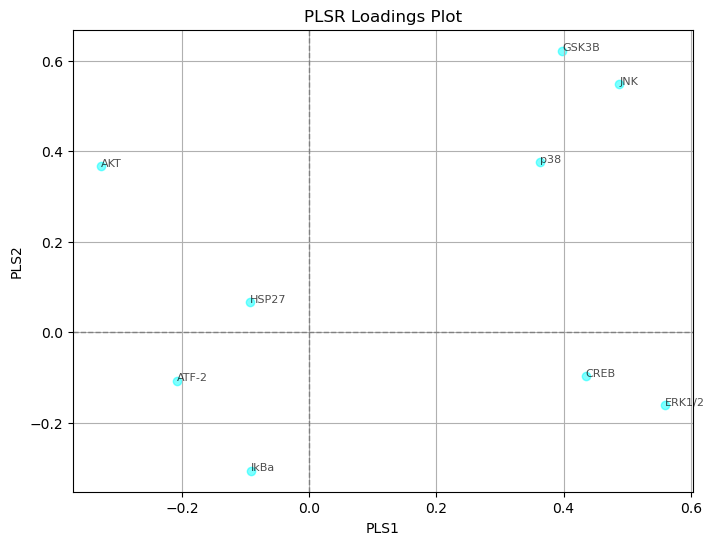

In [8]:
# PLSR with 2 components
pls_model = PLSRegression(n_components=2)
pls_model.fit(X, Y)
T_pls = pls_model.transform(X)

# variance explained in Y by each PLS component
# plot the predictions versus the actuals
Y_pred = pls_model.predict(X)
ss_total = np.sum((Y.values - np.mean(Y.values))**2)
ss_residual = np.sum((Y.values - Y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)


# measure fitness 
#fitness = 

plt.figure(figsize=(6, 6))
plt.scatter(Y.values, Y_pred, c='black', alpha=0.5)
plt.xlabel('Actual VPR')
plt.ylabel('Predicted VPR')
plt.title('PLSR: Actual vs Predicted VPR ncomp=2 \n$R^2$ = %0.2f' % r_squared)
plt.plot([Y.values.min(), Y.values.max()], [Y.values.min(), Y.values.max()], 'r--')
plt.grid()
plt.show()


# plot the scores from the PLSR
plt.figure(figsize=(8, 6))
plt.scatter(T_pls[:, 0], T_pls[:, 1], c='brown', alpha=0.5)
# annotate the points with the row labels from the original data
for i, txt in enumerate(df_data_sub_zscore.index):
    plt.annotate(txt, (T_pls[i, 0], T_pls[i, 1]), fontsize=8, alpha=0.7)    
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('PLS1')
plt.ylabel('PLS2')
plt.title('PLSR Scores Plot')
plt.grid()
plt.show()

# plot the loadings
plt.figure(figsize=(8, 6))
plt.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 1], c='cyan', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
# annotate the points with the column labels from the original data
for i, txt in enumerate(df_data_sub_zscore.columns):
    plt.annotate(txt, (pls_model.x_loadings_[i, 0], pls_model.x_loadings_[i, 1]), fontsize=8, alpha=0.7)
plt.xlabel('PLS1')
plt.ylabel('PLS2')
plt.title('PLSR Loadings Plot')
plt.grid()
plt.show()

In [ ]:
Y_pred